In [1]:
import numpy
from matplotlib import pyplot
import py_monte_carlo
import scipy.sparse
import scipy.linalg

## Including Transverse field

In [2]:
edges =  [((0,1),-1.0), ((1,2), -1.0), ((2,3), -1.0), ((3,4), -1.0), ((4, 0), -1.0)]
transverse = 1.0
nvars = 5

graph = py_monte_carlo.Lattice(edges)
graph.set_enable_semiclassical_update(True)
graph.set_transverse_field(transverse)

In [3]:
betas = [0.1, 0.5, 1.0, 2.5, 5.0, 10.0, 20.0, 40.0]

In [4]:
q_transverse_data = numpy.zeros(len(betas))
q_energies_data = numpy.zeros(len(betas))
for i, beta in enumerate(betas):
    results, energies = graph.run_quantum_monte_carlo_and_measure_spins(beta, 10000, 16, exponent=2)
    q_transverse_data[i] = numpy.mean(results, axis=0)
    q_energies_data[i] = numpy.mean(energies)

In [5]:
def make_ham_and_spin(nvars, edges, transverse):
    ham = numpy.zeros((2**nvars,2**nvars))
    for i in range(2**nvars):
        state = [(i >> j) & 1 for j in range(nvars)]
        h = 0.0
        for (vara, varb), j in edges:
            if state[vara] == state[varb]:
                h += j
            else:
                h -= j

        ham[i,i] += h
        for j in range(i+1, 2**nvars):
            b_state = [(j >> k) & 1 for k in range(nvars)]
            diffstate = [a^b for a,b in zip(state, b_state)]
            if sum(diffstate) != 1:
                continue
            for vark,s in enumerate(diffstate):
                if not s:
                    continue
                ham[i, j] = ham[i,j] + transverse
                ham[j, i] = ham[j,i] + transverse

    spin_diag = []
    for i in range(2**nvars):
        state = [(i >> j) & 1 for j in range(nvars)]
        spin_diag.append(numpy.sum(numpy.asarray(state)*2 - 1)**2)
    spin_op = numpy.diag(spin_diag)
    return ham, spin_op

ham, spin_op = make_ham_and_spin(nvars, edges, transverse)

In [6]:
ed_transverse_data = []
ed_transverse_energies = []
for beta in betas:
    expm = scipy.linalg.expm(-beta*ham)
    ed_transverse_data.append(numpy.trace(spin_op @ expm) / numpy.trace(expm))
    ed_transverse_energies.append(numpy.trace(ham @ expm) / numpy.trace(expm))

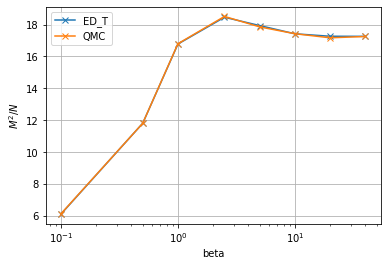

In [7]:
pyplot.plot(betas, ed_transverse_data, 'x-', label="ED_T")
pyplot.plot(betas, q_transverse_data, 'x-', label="QMC")
pyplot.xscale('log')
pyplot.legend()
pyplot.grid()
pyplot.xlabel("beta")
pyplot.ylabel("$M^2/N$")
pyplot.savefig("compare.png")
pyplot.show()

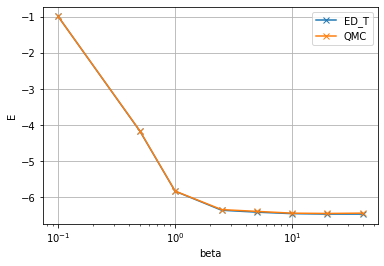

In [8]:
pyplot.plot(betas, ed_transverse_energies, 'x-', label="ED_T")
pyplot.plot(betas, q_energies_data, 'x-', label="QMC")
pyplot.xscale('log')
pyplot.legend()
pyplot.grid()
pyplot.xlabel("beta")
pyplot.ylabel("E")
pyplot.savefig("energies.png")
pyplot.show()

## Lattice stuff

Lets make a small 4-8 lattice, start with a single unit cell

In [9]:
edges = [
    ((0, 1), -1.0),
    ((1, 2), 1.0),
    ((2, 3), 1.0),
    ((3, 0), 1.0)
]
nvars = 4
transverse = 1.0

graph = py_monte_carlo.Lattice(edges)
graph.set_enable_semiclassical_update(True)
graph.set_transverse_field(transverse)

In [10]:
betas = [0.1, 0.5, 1.0, 2.5, 5.0, 10.0, 20.0, 40.0]

In [11]:
lattice_qmc_data = numpy.zeros(len(betas))
lattice_qmc_energy = numpy.zeros(len(betas))
for i, beta in enumerate(betas):
    results, energies = graph.run_quantum_monte_carlo_and_measure_spins(beta, 10000, 8, exponent=2)
    lattice_qmc_data[i] = numpy.mean(results, axis=0)
    lattice_qmc_energy[i] = numpy.mean(energies)

In [12]:
lattice_ed_data = []
lattice_ed_energy = []

ham, spin_op = make_ham_and_spin(nvars, edges, transverse)

for beta in betas:
    expm = scipy.linalg.expm(-beta*ham)
    lattice_ed_data.append(numpy.trace(spin_op @ expm) / numpy.trace(expm))
    lattice_ed_energy.append(numpy.trace(ham @ expm) / numpy.trace(expm))

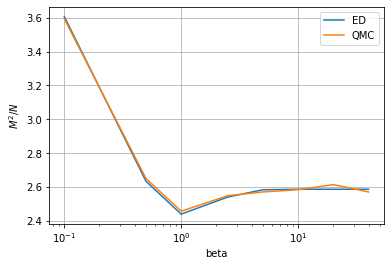

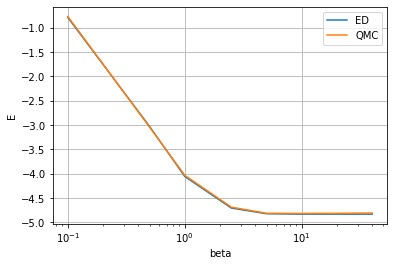

In [13]:
pyplot.plot(betas, lattice_ed_data, label='ED')
pyplot.plot(betas, lattice_qmc_data, label='QMC')
pyplot.xscale("log")
pyplot.legend()
pyplot.grid()
pyplot.xlabel("beta")
pyplot.ylabel("$M^2/N$")
pyplot.show()

pyplot.plot(betas, lattice_ed_energy, label='ED')
pyplot.plot(betas, lattice_qmc_energy, label='QMC')
pyplot.xscale("log")
pyplot.grid()
pyplot.legend()
pyplot.xlabel("beta")
pyplot.ylabel("E")
pyplot.show()

In [14]:
hs = 10**numpy.linspace(-1, 1, 10)
beta = 1.0

In [15]:
lattice_qmc_data_hs = numpy.zeros(len(hs))
lattice_qmc_energy_hs = numpy.zeros(len(hs))
graph = py_monte_carlo.Lattice(edges)
graph.set_enable_semiclassical_update(True)

for i, h in enumerate(hs):
    graph.set_transverse_field(h)
    results, energies = graph.run_quantum_monte_carlo_and_measure_spins(beta, 10000, 8, exponent=2)
    lattice_qmc_data_hs[i] = numpy.mean(results, axis=0)
    lattice_qmc_energy_hs[i] = numpy.mean(energies)

In [16]:
lattice_ed_data_hs = []
lattice_ed_energy_hs = []

for h in hs:
    ham, spin_op = make_ham_and_spin(nvars, edges, h)
    expm = scipy.linalg.expm(-beta*ham)
    lattice_ed_data_hs.append(numpy.trace(spin_op @ expm) / numpy.trace(expm))
    lattice_ed_energy_hs.append(numpy.trace(ham @ expm) / numpy.trace(expm))

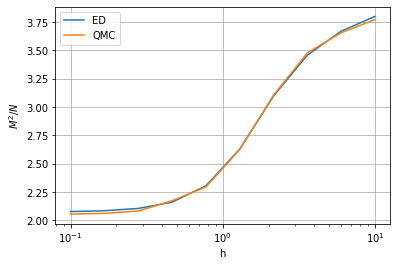

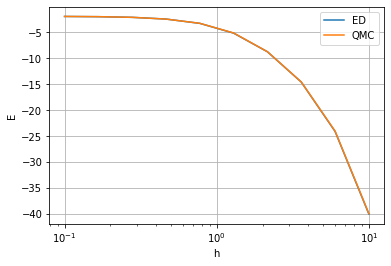

In [17]:
pyplot.plot(hs, lattice_ed_data_hs, label='ED')
pyplot.plot(hs, lattice_qmc_data_hs, label='QMC')
pyplot.xscale("log")
pyplot.legend()
pyplot.grid()
pyplot.xlabel("h")
pyplot.ylabel("$M^2/N$")
pyplot.show()

pyplot.plot(hs, lattice_ed_energy_hs, label='ED')
pyplot.plot(hs, lattice_qmc_energy_hs, label='QMC')
pyplot.xscale("log")
pyplot.grid()
pyplot.legend()
pyplot.xlabel("h")
pyplot.ylabel("E")
pyplot.show()

### Two unit cell lattice

In [18]:
edges = [
    ((0, 1), -1.0),
    ((1, 2), 1.0),
    ((2, 3), 1.0),
    ((3, 0), 1.0),
    
    ((1, 7), 1.0),
    
    ((4, 5), -1.0),
    ((5, 6), 1.0),
    ((6, 7), 1.0),
    ((7, 4), 1.0)
]
nvars = 8
transverse = 1.0

graph = py_monte_carlo.Lattice(edges)
graph.set_enable_semiclassical_update(True)
graph.set_transverse_field(transverse)

In [19]:
large_lattice_qmc_data = numpy.zeros(len(betas))
large_lattice_qmc_energy = numpy.zeros(len(betas))

for i, beta in enumerate(betas):
    print(beta)
    results, energies = graph.run_quantum_monte_carlo_and_measure_spins(beta, 10000, 8, exponent=2)
    large_lattice_qmc_data[i] = numpy.mean(results, axis=0)
    large_lattice_qmc_energy[i] = numpy.mean(energies)

0.1
0.5
1.0
2.5
5.0
10.0
20.0
40.0


In [20]:
large_lattice_ed_data = []
large_lattice_ed_energy = []

ham, spin_op = make_ham_and_spin(nvars, edges, transverse)

for beta in betas:
    expm = scipy.linalg.expm(-beta*ham)
    large_lattice_ed_data.append(numpy.trace(spin_op @ expm) / numpy.trace(expm))
    large_lattice_ed_energy.append(numpy.trace(ham @ expm) / numpy.trace(expm))

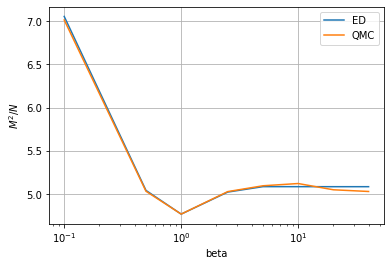

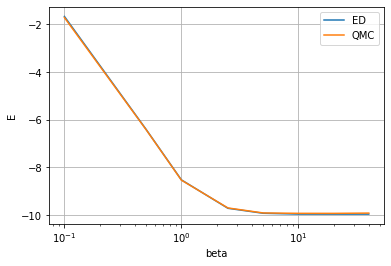

In [21]:
pyplot.plot(betas, large_lattice_ed_data, label='ED')
pyplot.plot(betas, large_lattice_qmc_data, label='QMC')
pyplot.xscale("log")
pyplot.legend()
pyplot.grid()
pyplot.xlabel("beta")
pyplot.ylabel("$M^2/N$")
pyplot.show()

pyplot.plot(betas, large_lattice_ed_energy, label='ED')
pyplot.plot(betas, large_lattice_qmc_energy, label='QMC')
pyplot.xscale("log")
pyplot.grid()
pyplot.legend()
pyplot.xlabel("beta")
pyplot.ylabel("E")
pyplot.show()

In [22]:
hs = 10**numpy.linspace(-1, 1, 10)
beta = 1.0

In [23]:
large_lattice_qmc_data_hs = numpy.zeros(len(hs))
large_lattice_qmc_energy_hs = numpy.zeros(len(hs))
graph = py_monte_carlo.Lattice(edges)
graph.set_enable_semiclassical_update(True)

for i, h in enumerate(hs):
    graph.set_transverse_field(h)
    results, energies = graph.run_quantum_monte_carlo_and_measure_spins(beta, 10000, 8, exponent=2)
    large_lattice_qmc_data_hs[i] = numpy.mean(results, axis=0)
    large_lattice_qmc_energy_hs[i] = numpy.mean(energies)

In [24]:
large_lattice_ed_data_hs = []
large_lattice_ed_energy_hs = []

for h in hs:
    ham, spin_op = make_ham_and_spin(nvars, edges, h)
    expm = scipy.linalg.expm(-beta*ham)
    large_lattice_ed_data_hs.append(numpy.trace(spin_op @ expm) / numpy.trace(expm))
    large_lattice_ed_energy_hs.append(numpy.trace(ham @ expm) / numpy.trace(expm))

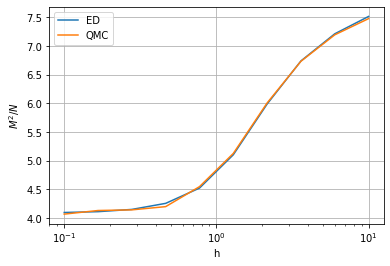

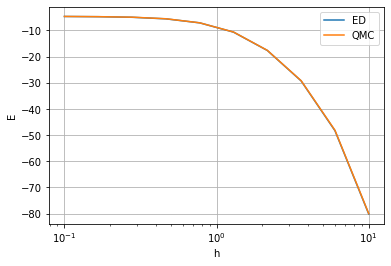

In [25]:
pyplot.plot(hs, large_lattice_ed_data_hs, label='ED')
pyplot.plot(hs, large_lattice_qmc_data_hs, label='QMC')
pyplot.xscale("log")
pyplot.legend()
pyplot.grid()
pyplot.xlabel("h")
pyplot.ylabel("$M^2/N$")
pyplot.show()

pyplot.plot(hs, large_lattice_ed_energy_hs, label='ED')
pyplot.plot(hs, large_lattice_qmc_energy_hs, label='QMC')
pyplot.xscale("log")
pyplot.grid()
pyplot.legend()
pyplot.xlabel("h")
pyplot.ylabel("E")
pyplot.show()

## Superclique

In [26]:
nvars = 8

edges = [((i,j), 1.0) for i in range(nvars) for j in range(i+1, nvars)]
transverse = 1.0

graph = py_monte_carlo.Lattice(edges)
graph.set_enable_semiclassical_update(True)
graph.set_transverse_field(transverse)

In [27]:
clique_qmc_data = numpy.zeros(len(betas))
clique_qmc_energy = numpy.zeros(len(betas))

for i, beta in enumerate(betas):
    print(beta)
    results, energies = graph.run_quantum_monte_carlo_and_measure_spins(beta, 10000, 8, exponent=2)
    clique_qmc_data[i] = numpy.mean(results, axis=0)
    clique_qmc_energy[i] = numpy.mean(energies)

0.1
0.5
1.0
2.5
5.0
10.0
20.0
40.0


In [28]:
clique_ed_data = []
clique_ed_energy = []

ham, spin_op = make_ham_and_spin(nvars, edges, transverse)

for beta in betas:
    expm = scipy.linalg.expm(-beta*ham)
    clique_ed_data.append(numpy.trace(spin_op @ expm) / numpy.trace(expm))
    clique_ed_energy.append(numpy.trace(ham @ expm) / numpy.trace(expm))

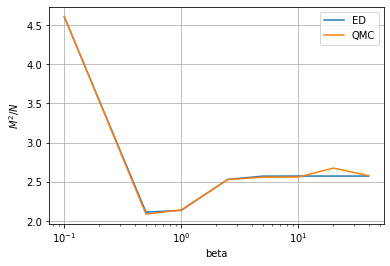

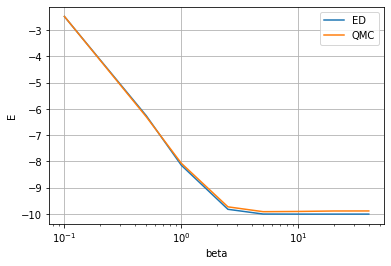

In [29]:
pyplot.plot(betas, clique_ed_data, label='ED')
pyplot.plot(betas, clique_qmc_data, label='QMC')
pyplot.xscale("log")
pyplot.legend()
pyplot.grid()
pyplot.xlabel("beta")
pyplot.ylabel("$M^2/N$")
pyplot.show()

pyplot.plot(betas, clique_ed_energy, label='ED')
pyplot.plot(betas, clique_qmc_energy, label='QMC')
pyplot.xscale("log")
pyplot.grid()
pyplot.legend()
pyplot.xlabel("beta")
pyplot.ylabel("E")
pyplot.show()

In [30]:
hs = 10**numpy.linspace(-1, 1, 10)
beta = 1.0

In [31]:
clique_qmc_data_hs = numpy.zeros(len(hs))
clique_qmc_energy_hs = numpy.zeros(len(hs))
graph = py_monte_carlo.Lattice(edges)
graph.set_enable_semiclassical_update(True)

for i, h in enumerate(hs):
    graph.set_transverse_field(h)
    results, energies = graph.run_quantum_monte_carlo_and_measure_spins(beta, 10000, 8, exponent=2)
    clique_qmc_data_hs[i] = numpy.mean(results, axis=0)
    clique_qmc_energy_hs[i] = numpy.mean(energies)

In [32]:
clique_ed_data_hs = []
clique_ed_energy_hs = []

for h in hs:
    ham, spin_op = make_ham_and_spin(nvars, edges, h)
    expm = scipy.linalg.expm(-beta*ham)
    clique_ed_data_hs.append(numpy.trace(spin_op @ expm) / numpy.trace(expm))
    clique_ed_energy_hs.append(numpy.trace(ham @ expm) / numpy.trace(expm))

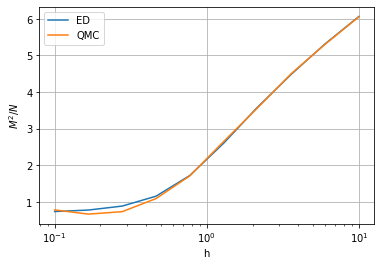

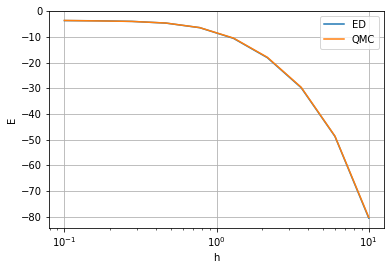

In [33]:
pyplot.plot(hs, clique_ed_data_hs, label='ED')
pyplot.plot(hs, clique_qmc_data_hs, label='QMC')
pyplot.xscale("log")
pyplot.legend()
pyplot.grid()
pyplot.xlabel("h")
pyplot.ylabel("$M^2/N$")
pyplot.show()

pyplot.plot(hs, clique_ed_energy_hs, label='ED')
pyplot.plot(hs, clique_qmc_energy_hs, label='QMC')
pyplot.xscale("log")
pyplot.grid()
pyplot.legend()
pyplot.xlabel("h")
pyplot.ylabel("E")
pyplot.show()